<a href="https://www.kaggle.com/code/tusharvilekar/3d-semantic-segmentation-presentation?scriptVersionId=149691784" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
! sudo apt-get install libsparsehash-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libsparsehash-dev
0 upgraded, 1 newly installed, 0 to remove and 74 not upgraded.
Need to get 71.7 kB of archives.
After this operation, 589 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libsparsehash-dev all 2.0.3-2 [71.7 kB]
Fetched 71.7 kB in 0s (436 kB/s)             
Selecting previously unselected package libsparsehash-dev.
(Reading database ... 113818 files and directories currently installed.)
Preparing to unpack .../libsparsehash-dev_2.0.3-2_all.deb ...
Unpacking libsparsehash-dev (2.0.3-2) ...
Setting up libsparsehash-dev (2.0.3-2) ...


In [2]:
! pip install --upgrade git+https://github.com/mit-han-lab/torchsparse.git@v2.0.0

  Cloning https://github.com/mit-han-lab/torchsparse.git (to revision v2.0.0) to /tmp/pip-req-build-cbvcsemf
  Running command git clone --filter=blob:none --quiet https://github.com/mit-han-lab/torchsparse.git /tmp/pip-req-build-cbvcsemf
  Running command git checkout -q 1a10fda15098f3bf4fa2d01f8bee53e85762abcf
  Resolved https://github.com/mit-han-lab/torchsparse.git to commit 1a10fda15098f3bf4fa2d01f8bee53e85762abcf
  Preparing metadata (setup.py) ... done
  Created wheel for torchsparse: filename=torchsparse-2.0.0b0-cp310-cp310-linux_x86_64.whl size=11898691 sha256=2630cfd6f2486297d2229712d90f55deb752969bc52d5819ef773f8837c06c8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-9xc7ydl6/wheels/68/62/3c/ac0c2b24db0ef3dd7baa6975f0ed15744c795b060677c3eb29
Successfully built torchsparse


In [3]:
! git clone https://github.com/Xplod4432/point-transformer.git
! pwd
! ls

Cloning into 'point-transformer'...
remote: Enumerating objects: 429, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 429 (delta 106), reused 58 (delta 55), pack-reused 262
Receiving objects: 100% (429/429), 109.32 KiB | 1.42 MiB/s, done.
Resolving deltas: 100% (216/216), done.
/kaggle/working
point-transformer


In [4]:
! cd point-transformer/lib/pointops && python setup.py install

/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://github.com/py

In [5]:
! pip install h5py pytorch-ignite numba tqdm

In [6]:
! rm -r 3D_Semantic_Segmentation

rm: cannot remove '3D_Semantic_Segmentation': No such file or directory


In [ ]:
! git clone https://github.com/Xplod4432/3D_Semantic_Segmentation.git
! cp -r /kaggle/input/street3d-h5/h5 /kaggle/working/3D_Semantic_Segmentation/data/Street3D/

In [ ]:
import time
import random
from typing import Any, Dict
from tqdm import tqdm
import numpy as np
import torch
import torch.utils.data
from torch import nn
#from torch.cuda import amp
import os
import h5py

from meters.s3dis import MeterS3DIS as metric
from torchsparse import SparseTensor
from torchsparse import nn as spnn
from torchsparse.utils.collate import sparse_collate_fn
from torchsparse.utils.quantize import sparse_quantize
from functools import partial
from core.schedulers import cosine_schedule_with_warmup

In [ ]:
## Uncomment to load the proper baseline model
from core.models import SPVCNN
#from core.models import MinkUNet as SPVCNN

In [ ]:
## or the proper attention enhanced baseline model (only one model should be used at a time)
#from models_street3d.spvcnn_se_point_global import SPVCNN
#from models_street3d.spvcnn_se_voxel_global import SPVCNN
#from models_street3d.spvcnn_cbam_point_global import SPVCNN
#from models_street3d.spvcnn_cbam_voxel_global import SPVCNN
#from models_street3d.spvcnn_knn_se_point import SPVCNN
#from models_street3d.spvcnn_knn_se_voxel import SPVCNN
#from models_street3d.spvcnn_knn_cbam_point import SPVCNN
#from models_street3d.spvcnn_knn_cbam_voxel import SPVCNN
#from models_street3d.spvcnn_pt_point import SPVCNN
#from models_street3d.spvcnn_pt_voxel import SPVCNN
#from models_street3d.spvcnn_lfa_point import SPVCNN
#from models_street3d.spvcnn_lfa_voxel import SPVCNN

#from models_street3d.minko_se_global import MinkUNet as SPVCNN
#from models_street3d.minko_cbam_global import MinkUNet as SPVCNN
#from models_street3d.minko_knn_se import MinkUNet as SPVCNN
#from models_street3d.minko_knn_se_fast import MinkUNet as SPVCNN
#from models_street3d.minko_knn_cbam import MinkUNet as SPVCNN
#from models_street3d.minko_knn_cbam_fast import MinkUNet as SPVCNN
#from models_street3d.minko_pt import MinkUNet as SPVCNN
#from models_street3d.minko_pt_fast import MinkUNet as SPVCNN
#from models_street3d.minko_lfa import MinkUNet as SPVCNN
#from models_street3d.minko_lfa_fast import MinkUNet as SPVCNN
## Use the 'fast' implementations only for inference, after the network is trained

In [ ]:
## Define the proper savepath
model_name = "spvcnn"
savepath = "/kaggle/output/Street3D_results/"+model_name

In [ ]:
## Define the proper training parameters
## Voxel size in meters (0.05 equals to a voxel of 0.05 X 0.05 X 0.05)
r = 0.05

## Batch Size
bs = 2

## Number of Epochs
ne = 15

## Learning rate is set to optimizer below

##-----------------------------------------------------------------------------

In [ ]:
# Function to calculate class weights based on the labels
def calculate_weights(labels):
    counts = np.zeros(5)
    labels = labels.cpu().numpy()
    for i in range(5):
        counts[i]+=np.sum(labels==i)
    frq = counts/np.sum(counts)
    return 1/(frq+0.00001)**0.5

In [ ]:
# Set random seeds for reproducibility
random.seed(2341)
np.random.seed(2341)
torch.manual_seed(2341)
torch.cuda.manual_seed_all(2341)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Get the current working directory
data_directory = '/kaggle/input/street3d-h5'


# Create a directory for saving model results
if not os.path.exists(savepath):
    os.makedirs(savepath)
else:
    print(f"the folder {savepath} exists change the savepath and try again")
    exit(0)

In [ ]:
# Create a class for the Street3D dataset
class shrec_dataset:

    def __init__(self,voxel_size,split=None) :
        # Initialize the dataset class.
        self.data = []  # List to store file paths of the dataset.
        self.train = True  # Indicate if it's a training dataset.
        self.voxel_size = voxel_size  # Voxel size in meters.
        self.split = split  # Specify the data split (e.g., 'train_part' or 'test').
        
        # Define the path to the dataset files (modify as needed).
        spath = data_directory + '/h5/train_part_80k'
        
        # Load file paths into the 'data' list.
        for file in os.listdir(spath):
            path = os.path.join(spath,file)
            self.data.append(path)
    
    def __getitem__(self, item) -> Dict[str, Any]:
        # Define how to get a specific item (i.e., data sample) from the dataset.
        item = item % len(self.data)  # Handle item indexing to loop through the dataset.
        path = self.data[item]
        inputs = np.fromfile(path, np.float32).reshape(-1, 4)  # Load point cloud data from a file.
        
        n = 80000  # Maximum number of points to use in each data sample.



        if len(inputs) > n and self.train and not self.split == 'train_part':
            # If it's a training sample and not from the 'train_part' split, randomly subsample to 'n' points.
            choices = np.random.choice(len(inputs), n, False)
            inputs = inputs[choices]

        if self.train:
            # Data augmentation for training samples.
            # Apply random rotation and scaling during training
            theta = np.random.uniform(0,2*np.pi)
            scale = np.random.uniform(0.95,1.05)
            rot_mat = np.array([[np.cos(theta),np.sin(theta),0],
                                [-np.sin(theta), np.cos(theta), 0],
                                [0,0,1]])
            inputs[:,:3] = np.dot(inputs[:,:3],rot_mat)*scale



        minpc = np.min(inputs[:,:3], axis=0, keepdims=True)
        inputs[:,:3] -= np.min(inputs[:,:3], axis=0, keepdims=True)

        # Extract coordinates and features from the loaded data.
        coords, feats = inputs[:,:3], inputs[:,:3]
        all_labels = inputs[:,-1]

        # Quantize the point cloud to a voxel grid using the specified voxel size.
        coords, indices, inverse_mapping = sparse_quantize(coords,
                                          self.voxel_size,
                                          return_index=True,
                                          return_inverse=True)

        # Convert data to PyTorch tensors.
        feats = feats[indices]
        labels = inputs[indices,-1]

        coords = torch.tensor(coords, dtype=torch.int)
        feats = torch.tensor(feats, dtype=torch.float)

        labels = torch.from_numpy(labels).long()
        
        # Create SparseTensor objects for input and label.
        input = SparseTensor(coords=coords, feats=feats)
        label = SparseTensor(coords=coords, feats=labels)

        if self.train:
           # Return the data as a dictionary with 'input' and 'label'.
           return {'input': input,
                  'label': label}
        else:
            # Return additional information for testing, such as all labels and inverse mapping.
            return {'input': input,
                   'label': label,
                   'all_labs': all_labels,
                   'inverse': inverse_mapping}

    def __len__(self):
        if self.train and not self.split == 'train_part':
            # Control the dataset length for training (e.g., loop through the data multiple times).
            return 10 * len(self.data)  # Increase the effective length for non-'train_part' splits
        return len(self.data)  # Return the length of the data for the current split

    def calculate_stats(self):
        return self.stats  # Calculate and return dataset statistics

In [ ]:
# Define the source directory for dataset files.
source = data_directory + 'h5/train_part_80k'

# List all files in the source directory and shuffle the list.
files = os.listdir(source)
random.shuffle(files)
sourcetrain = files

# Create a text file for logging training information.
ftrain = open(savepath+"/train.txt",'w')

# Specify the dataset to use with the given voxel size and split.
dataset = shrec_dataset(voxel_size=r,split='train_part')

# Initialize evaluation metrics for mean IoU and overall accuracy.
metricmiou = metric(num_classes=5)
metricoa = metric(metric='overall',num_classes=5)


# Create a DataLoader for batched data loading and preprocessing.
dataflow = torch.utils.data.DataLoader(
    dataset,
    shuffle=True,
    batch_size=bs,
    collate_fn=sparse_collate_fn,
    num_workers=1,
#    persistent_workers=True
)


# Create the neural network model for 3D point cloud classification.
model = SPVCNN(num_classes=5, cr=1,pres=1,vres=1,inc=3)

# Move the model to the GPU.
model.cuda()

# Define the loss function (cross-entropy), and initialize best IoU and accuracy values.
criterion = nn.CrossEntropyLoss()
bestmiou=-1
bestoa=0

# Define the optimizer with specific settings (SGD with momentum, weight decay, and learning rate).
optimizer = torch.optim.SGD(model.parameters(),momentum=0.9,nesterov=True,weight_decay=1.0e-4,lr=0.024)


# Create a learning rate scheduler based on a custom function.
scheduler = torch.optim.lr_scheduler.LambdaLR(
            optimizer,
            lr_lambda=partial(cosine_schedule_with_warmup,
                              num_epochs=ne,
                              batch_size=bs,
                              dataset_size=len(dataset)))


# Training loop for a specified number of epochs.
for i in range(ne):
    model.train() # Set the model in training mode
    for idx, feed_dict in enumerate(tqdm(dataflow)):
        # Load a batch of input data and labels.
        inputs = feed_dict['input'].to('cuda')
        labels = feed_dict['label'].to('cuda')
        
        # Adjust the loss function's class weights based on label frequencies.
        criterion.weight = torch.from_numpy(calculate_weights(labels.feats)).cuda().float()
        
        # Forward pass: compute model predictions and calculate the loss.
        outputs = model(inputs)
        loss = criterion(outputs, labels.feats)
        
        # Update the evaluation metrics (mean IoU and overall accuracy).
        metricmiou.update(outputs,labels.feats)
        metricoa.update(outputs,labels.feats)
        
        # Backpropagation and optimization step.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step() # Adjust the learning rate according to the schedule.
    
    # Compute and log the mean IoU and overall accuracy for the current epoch.
    miou = metricmiou.compute(True)
    oa = metricoa.compute()
    print(f"epoch is {i} oa is {oa} and miou is {miou}")
    print(f"{i} {oa} {miou}",file=ftrain)
    
    # Reset the evaluation metrics for the next epoch.
    metricmiou.reset()
    metricoa.reset()
    
    # Save the model's state (parameters) after each epoch.
    torch.save(model.state_dict(),savepath+'/shrec.pth')

In [18]:
! git clone https://github.com/Xplod4432/3D_Semantic_Segmentation.git
! cp -r /kaggle/input/street3d-h5/h5 /kaggle/working/3D_Semantic_Segmentation/data/Street3D/

fatal: destination path '3D_Semantic_Segmentation' already exists and is not an empty directory.


In [11]:
import csv

# Read the text from the file
with open('/kaggle/working/3D_Semantic_Segmentation/Street3D_results/spvcnn/out-train.log', 'r') as file:
    text = file.read()

# Split the data into lines
lines = text.strip().split('\n')

# Initialize variables
csv_data = []
class_iou = [0.0] * 5
oa = 0.0
miou = 0.0

# Process each line of the data
for line in lines:
    if line.startswith("class"):
        parts = line.split()
        class_iou[int(parts[1])] = float(parts[5])
    elif line.startswith("epoch"):
        parts = line.split()
        epoch = int(parts[2])
        oa = float(parts[5])
        miou = float(parts[9])
        csv_data.append([epoch] + class_iou + [oa, miou])

# Write the data to a CSV file
import csv

with open('output.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Epoch', 'Class 0 IOU', 'Class 1 IOU', 'Class 2 IOU', 'Class 3 IOU', 'Class 4 IOU', 'OA', 'MIOU'])
    csv_writer.writerows(csv_data)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
# Load the CSV data into a DataFrame
data = pd.read_csv('output.csv')

# Extract data for plotting
epochs = data['Epoch']
class_iou_columns = [f'Class {i} IOU' for i in range(5)]
class_miou_columns = [f'Class {i} IOU' for i in range(5)]
oa = data['OA']
miou = data['MIOU']

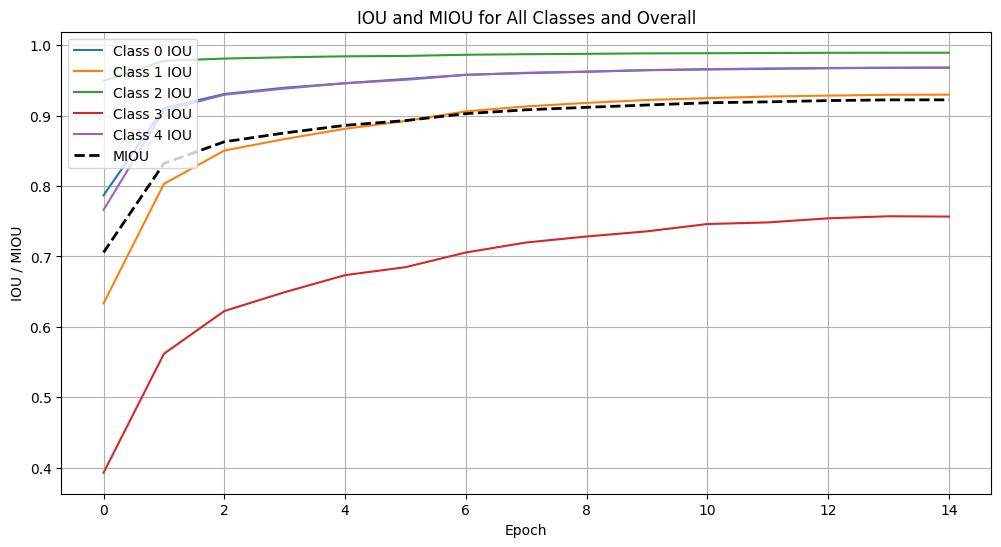

In [14]:
# Plot IOU and MIOU for each class
plt.figure(figsize=(12, 6))

for i in range(5):
    plt.plot(epochs, data[class_iou_columns[i]], label=f'Class {i} IOU')

# Plot overall OA and MIOU
plt.plot(epochs, miou, label='MIOU', linestyle='--', color='black', linewidth=2)

# Set labels and title for the IOU/MIOU graph
plt.xlabel('Epoch')
plt.ylabel('IOU / MIOU')
plt.title('IOU and MIOU for All Classes and Overall')
plt.grid(True)
plt.legend(loc='upper left')

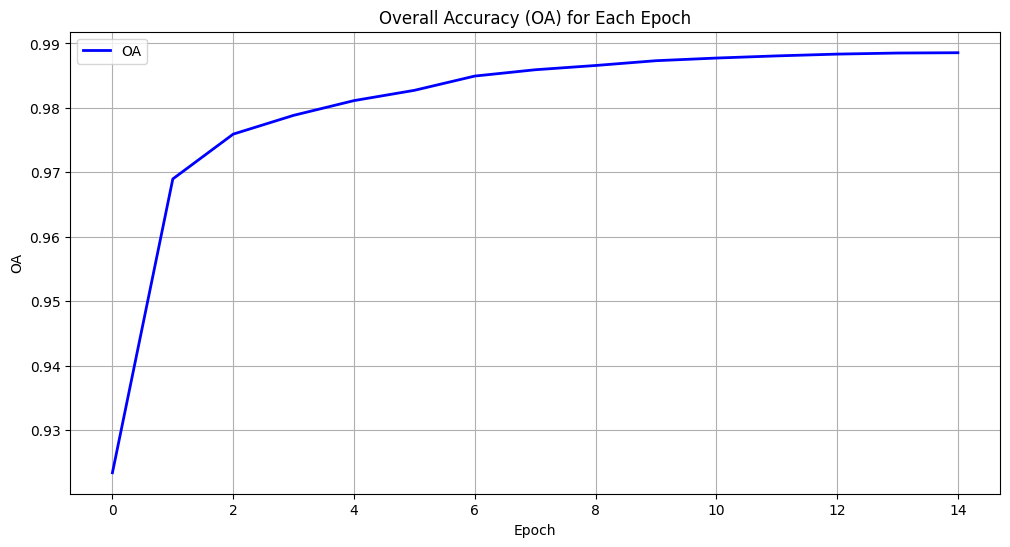

In [15]:
# Create a separate graph for OA
plt.figure(figsize=(12, 6))
plt.plot(epochs, oa, label='OA', color='blue', linewidth=2)

# Set labels and title for the OA graph
plt.xlabel('Epoch')
plt.ylabel('OA')
plt.title('Overall Accuracy (OA) for Each Epoch')
plt.grid(True)
plt.legend()

In [16]:
# Show both graphs
plt.show()

In [19]:
! cd 3D_Semantic_Segmentation && python scripts/Street3D/street3d_inference_all.py

21775781
100%|█████████████████████████████████████████| 845/845 [02:42<00:00,  5.19it/s]
class 0 the iou is 0.9345679498289945
class 1 the iou is 0.853710850833867
class 2 the iou is 0.9792196889906827
class 3 the iou is 0.6943603168646825
class 4 the iou is 0.9336856260775742
 testing oa is 0.9771292495908489 and miou is 0.8791088865191602

 Confusion matrix is:
tensor([[    0.9655,     0.0018,     0.0123,     0.0031,     0.0173],
        [    0.0143,     0.9601,     0.0187,     0.0002,     0.0066],
        [    0.0073,     0.0030,     0.9860,     0.0007,     0.0030],
        [    0.0866,     0.0017,     0.0059,     0.8294,     0.0764],
        [    0.0158,     0.0048,     0.0038,     0.0031,     0.9724]])
